In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, fbeta_score, roc_curve, confusion_matrix, precision_recall_curve

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

from inspect import signature
from sklearn.metrics import average_precision_score

In [154]:
##Making scorers
f_recall = make_scorer(fbeta_score, beta = 1.1) ## More weight towards recall

In [155]:
df = pd.read_pickle('kickstarter_analysis.pkl')
df = df.dropna()

In [156]:
## Selecting Features
features=['country','img_count', 'vid_count',
          'usd_goal', 'description_len', 'blurb_len', 
          'slug_len', 'med_rewards','category_core', 
          'reward_len', 'created_month', 'created_weekday', 
          'deadline_month', 'deadline_weekday', 
          'length_of_project']
dependent=['failed']
toscale = ['img_count', 'vid_count', 'usd_goal', 'description_len', 
           'blurb_len', 'slug_len', 
           'med_rewards', 'reward_len', 'length_of_project']

X=df[features]
y=df[dependent]

In [157]:
## Getting dummy variables
X = pd.get_dummies(X, drop_first = True)
y = y.values.ravel()

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.3, random_state = 42)

In [159]:
## Implementing A Robust Scaler
from sklearn.compose import ColumnTransformer
robust_transformer = Pipeline(steps = [ ('robust', RobustScaler()) ] )
preprocessor = ColumnTransformer(remainder = 'passthrough', 
                                transformers = [('rb', robust_transformer, toscale)])
preprocessor.fit(X)
X_scale = preprocessor.transform(X)

In [160]:
## getting scaled training data
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_scale, y, 
                                                   test_size = 0.3, random_state = 42)

# Logistic Regression

### Initial Model

In [161]:
clf = LogisticRegression(solver='liblinear')
clf.fit(Xs_train, ys_train)

training = clf.predict(Xs_train)
y_pred = clf.predict(Xs_test)

train_acc = fbeta_score(ys_train, training, beta = 1.1)
test_acc = fbeta_score(ys_test, y_pred, beta = 1.1)

print("Training acc_score: {:.2f}% \nTesting acc_score: {:.2f}%".format(train_acc*100, test_acc*100))

Training acc_score: 69.55% 
Testing acc_score: 69.63%


### GridSearch on Logistic Regression to find optimal parameters

In [162]:
params = {'C':[0.0001, 0.001, 0.1, 1, 10, 100]}
clf = LogisticRegression(solver = 'liblinear')
gs_cv = GridSearchCV(clf, param_grid = params, cv = 5, scoring = f_recall)
gs_cv.fit(Xs_train, ys_train)


print('The best parameters are: {} \nand the best score is: {:.2f}%'.format(gs_cv.best_params_, gs_cv.best_score_*100))

The best parameters are: {'C': 0.001} 
and the best score is: 69.60%


### Using CV with optimal parameters

In [11]:
X_arr = X_scale
final = 0
clf = LogisticRegression(solver='liblinear', C=0.001)
for train, test in KFold(n_splits=10).split(X_arr):
    clf.fit(X_arr[train], y[train])
    pred = clf.predict(X_arr[test])
    acc = fbeta_score(y[test], pred, beta = 1.1)
    final += acc
    
final = final / 10 # n of folds
print("CV Score: {:.2f}%".format(final*100))

CV Score: 69.77%


### Viewing Precision/Recall graphically

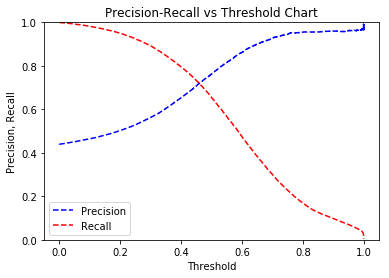

In [12]:
clf = LogisticRegression(solver = 'liblinear', C = 0.001)
clf.fit(Xs_train, ys_train)

y_probs = clf.predict_proba(Xs_test)

precision, recall, thresholds = precision_recall_curve(ys_test, y_probs[:,1])

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

## Source
## https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

# SVM

In [13]:
from sklearn.svm import LinearSVC

### Initial SVM model using LinearSVC

In [14]:
svc = LinearSVC()
%time svc.fit(Xs_train, ys_train)
%time y_pred = svc.predict(Xs_test)

score = fbeta_score(ys_test, y_pred, beta = 1.1)
print("Linear SVC Score: {:.2f}%".format(score*100))

CPU times: user 30.8 s, sys: 167 ms, total: 31 s
Wall time: 31.2 s
CPU times: user 7.25 ms, sys: 360 µs, total: 7.61 ms
Wall time: 4.81 ms
Linear SVC Score: 68.92%


/Users/Matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Adjusting maximum iterations to 2000

In [15]:
svc = LinearSVC(max_iter = 2000)
%time svc.fit(Xs_train, ys_train)
%time y_pred = svc.predict(Xs_test)

score = fbeta_score(ys_test, y_pred, beta = 1.1)
print("Linear SVC Score: {:.2f}%".format(score*100))

CPU times: user 1min 1s, sys: 341 ms, total: 1min 1s
Wall time: 1min 3s
CPU times: user 7.03 ms, sys: 182 µs, total: 7.21 ms
Wall time: 4.39 ms
Linear SVC Score: 68.84%


/Users/Matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Adjusting maximum iterations to 4000

In [16]:
svc = LinearSVC(max_iter = 4000)
%time svc.fit(Xs_train, ys_train)
%time y_pred = svc.predict(Xs_test)

score = fbeta_score(ys_test, y_pred, beta = 1.1)
print("Linear SVC Score: {:.2f}%".format(score*100))

CPU times: user 1min 58s, sys: 580 ms, total: 1min 59s
Wall time: 2min
CPU times: user 6.52 ms, sys: 211 µs, total: 6.73 ms
Wall time: 4.26 ms
Linear SVC Score: 68.67%


/Users/Matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

### Initial KNN Classifier

In [18]:
knn = KNeighborsClassifier()
%time knn.fit(Xs_train, ys_train)
%time y_pred = knn.predict(Xs_test)

score = fbeta_score(ys_test, y_pred, beta = 1.1)
print("KNN Score: {:.2f}%".format(score*100))

CPU times: user 913 ms, sys: 12.7 ms, total: 925 ms
Wall time: 929 ms
CPU times: user 8min 43s, sys: 1.26 s, total: 8min 44s
Wall time: 8min 46s
KNN Score: 62.34%


# Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

### Initial Random Forest Classifier

In [10]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

train_score = fbeta_score(y_train, train_pred, beta = 1.1)
score = fbeta_score(y_test, y_pred, beta = 1.1)

print("RF Training Score: {:.2f}% \nRF Testing Score: {:.2f}%".format(train_score*100, score*100))

/Users/Matt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF Training Score: 98.19% 
RF Testing Score: 68.56%


### Changing n_estimators

In [13]:
clf = RandomForestClassifier(n_estimators = 100) ##Setting to default in future sklearn versions
clf.fit(X_train, y_train)

train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

train_score = fbeta_score(y_train, train_pred, beta = 1.1)
score = fbeta_score(y_test, y_pred, beta = 1.1)

print("RF Training Score: {:2f}% \nRF Testing Score: {:.2f}%".format(train_score*100, score*100))

RF Training Score: 100.000000% 
RF Testing Score: 72.57%


### Getting best hyperparameters using RandomizedSearchCV

In [12]:
from sklearn.model_selection import RandomizedSearchCV

In [24]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 30, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [25]:
pprint(params)

{'bootstrap': [True, False],
 'max_depth': [10, 12, 14, 16, 18, 21, 23, 25, 27, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500]}


In [26]:
clf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=clf,param_distributions=params, 
                               cv = 3,scoring=f_recall, n_jobs = -1, verbose=3)

In [27]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 12, 14, 16, 18, 21, 23, 25, 27, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=1.1), verbose=3)

In [28]:
best = rf_random.best_params_

In [29]:
print(best)

{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


### RandomForest Classifier using tuned hyperparameters

In [14]:
clf = RandomForestClassifier(n_estimators = 200, min_samples_split = 10, min_samples_leaf = 1, 
                            max_features = 'auto', max_depth = None, bootstrap = True) 
clf.fit(X_train, y_train)


train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

train_score = fbeta_score(y_train, train_pred, beta = 1.1)
score = fbeta_score(y_test, y_pred, beta = 1.1)

print("RF Training Score: {:2f}% \nRF Testing Score: {:.2f}%".format(train_score*100, score*100))

RF Training Score: 93.076661% 
RF Testing Score: 72.84%


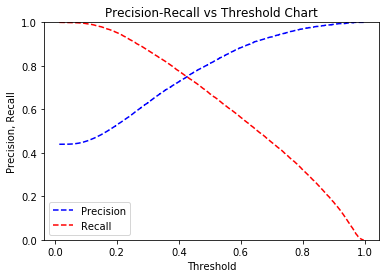

In [15]:
y_probs = clf.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:,1])

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

### Tuned hyperparameters in kfold test

In [16]:
score = 0
folds = 5
rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 10, min_samples_leaf = 1, 
                            max_features = 'auto', max_depth = None, bootstrap = True) 
for train, test in KFold(n_splits = folds).split(X_train.values):
    rf.fit(X_train.values[train], y_train[train])
    pred = rf.predict(X_test.values)
    fb = fbeta_score(y_test, pred, beta = 1.1)
    score += fb

score = score / folds

print("Final score: {:.2f}%".format(score * 100))

0.7275726948129726
1.4542324006826486
2.1816909602911676
2.9100651729865583
3.6375951235353186
Final score: 72.75%


# Analysis on Ensemble Method

In [163]:
df = pd.read_pickle('kickstarter_NB.pkl')
df = df.dropna()

## Clean up from predictions
type_ints = ['MNB_Blurb_All', 'MNB_Blurb_Cat', 'MNB_Desc_All', 'MNB_Desc_Cat']
for i in type_ints:
    df[i] = df[i].astype(int)

In [164]:
## Selecting Features
base=['country','img_count', 'vid_count',
          'usd_goal', 'description_len', 'blurb_len', 
          'slug_len', 'med_rewards','category_core', 
          'reward_len', 'created_month', 'created_weekday', 
          'deadline_month', 'deadline_weekday', 
          'length_of_project']
nb_all = ['MNB_Blurb_All', 'MNB_Desc_All']
nb_cat = ['MNB_Blurb_Cat', 'MNB_Desc_Cat']
dependent=['failed']

### RandomForest Classifier with MNB_All

In [23]:
feature = base + nb_all

X=df[feature]
y=df[dependent]

In [24]:
## Getting dummy variables
X = pd.get_dummies(X, drop_first = True)
y = y.values.ravel()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.3, random_state = 42)

In [28]:
clf = RandomForestClassifier(n_estimators = 200, min_samples_split = 10, min_samples_leaf = 1, 
                            max_features = 'auto', max_depth = None, bootstrap = True) 
clf.fit(X_train, y_train)


train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

train_score = fbeta_score(y_train, train_pred, beta = 1.1)
score = fbeta_score(y_test, y_pred, beta = 1.1)

print("RF Training Score: {:2f}% \nRF Testing Score: {:.2f}%".format(train_score*100, score*100))

RF Training Score: 92.746600% 
RF Testing Score: 74.50%


### RandomForest Classifier with MNB_Categories

In [29]:
feature = base + nb_cat

X= pd.get_dummies(df[feature], drop_first = True)
y=df[dependent].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.3, random_state = 42)

In [30]:
clf = RandomForestClassifier(n_estimators = 200, min_samples_split = 10, min_samples_leaf = 1, 
                            max_features = 'auto', max_depth = None, bootstrap = True) 
clf.fit(X_train, y_train)


train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

train_score = fbeta_score(y_train, train_pred, beta = 1.1)
score = fbeta_score(y_test, y_pred, beta = 1.1)

print("RF Training Score: {:2f}% \nRF Testing Score: {:.2f}%".format(train_score*100, score*100))

RF Training Score: 92.393667% 
RF Testing Score: 77.41%


# Threshold Analysis

In [31]:
df = pd.read_pickle('kickstarter_NB.pkl')
df = df.dropna()

## Clean up from predictions
type_ints = ['MNB_Blurb_All', 'MNB_Blurb_Cat', 'MNB_Desc_All', 'MNB_Desc_Cat']
for i in type_ints:
    df[i] = df[i].astype(int)

In [33]:
## Selecting Features
features=['country','img_count', 'vid_count',
          'usd_goal', 'description_len', 'blurb_len', 
          'slug_len', 'med_rewards','category_core', 
          'reward_len', 'created_month', 'created_weekday', 
          'deadline_month', 'deadline_weekday', 
          'length_of_project','MNB_Blurb_Cat', 'MNB_Desc_Cat']
dependent=['failed']

In [34]:
X= pd.get_dummies(df[features], drop_first = True)
y=df[dependent].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.3, random_state = 42)

In [35]:
clf = RandomForestClassifier(n_estimators = 200, min_samples_split = 10, min_samples_leaf = 1, 
                            max_features = 'auto', max_depth = None, bootstrap = True) 

In [36]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [130]:
y_probs = clf.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:,1])

In [131]:
beta = 1.1
betatwo = beta**2

fbeta = (1 + betatwo) * precision[:-1] * recall[:-1] / (betatwo * precision[:-1] + recall[:-1])

In [132]:
print("Maximum fbeta score: {:.3f}%".format(np.amax(fbeta)*100))
ind = np.where(fbeta == np.amax(fbeta))[0][0]
best_thresh = thresholds[ind]
print("Threshold of {:.4f}".format(best_thresh))

Maximum fbeta score: 78.848%
Threshold of 0.3840


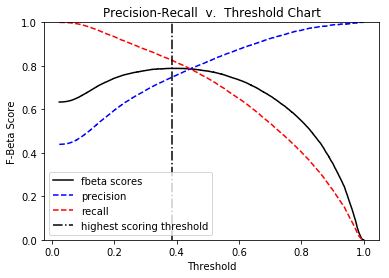

In [146]:

plt.title("Precision-Recall  v.  Threshold Chart")
plt.plot(thresholds, fbeta, "k", label = 'fbeta scores')
plt.plot(thresholds, precision[:-1], "b--", label = 'precision')
plt.plot(thresholds, recall[:-1], "r--", label = 'recall')
plt.axvline(x=best_thresh, color='k', linestyle='-.', label='highest scoring threshold')
plt.ylabel("F-Beta Score")
plt.xlabel("Threshold")
plt.legend(loc = 'lower left')
plt.ylim([0, 1])
plt.show()

### RF Classifier with threshold

In [135]:
train_pred = clf.predict_proba(X_train)[:,1] > .384
y_pred = clf.predict_proba(X_test)[:,1] > .384

train_score = fbeta_score(y_train, train_pred, beta = 1.1)
score = fbeta_score(y_test, y_pred, beta = 1.1)

print("RF Training Score: {:4f}% \nRF Testing Score: {:.4f}%".format(train_score*100, score*100))

RF Training Score: 93.748025% 
RF Testing Score: 78.8462%


### RF Classifier w/ threshold in kfold test

In [136]:
score = 0
folds = 5
rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 10, min_samples_leaf = 1, 
                            max_features = 'auto', max_depth = None, bootstrap = True) 
for train, test in KFold(n_splits = folds).split(X_train.values):
    rf.fit(X_train.values[train], y_train[train])
    pred = rf.predict_proba(X_test.values)[:,1] > .384
    fb = fbeta_score(y_test, pred, beta = 1.1)
    score += fb

score = score / folds

print("Final score: {:.4f}%".format(score * 100))

Final score: 78.7500%
